<a href="https://colab.research.google.com/github/asmaakhaledd/PID-NN/blob/LSTM-PID/PID-NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install numpy pandas tensorflow control matplotlib xmltodict scikit-learn

In [4]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import datetime

Load XML Data

In [5]:
#Automatically loads all XML files (5 training, 5 testing)
train_files = sorted(glob.glob("/content/drive/MyDrive/GP PID/dataset/*-ws-training.xml"))
test_files = sorted(glob.glob("/content/drive/MyDrive/GP PID/dataset/*-ws-testing.xml"))

Check Corrupted XML File

In [6]:
import xml.etree.ElementTree as ET

for file in train_files + test_files:
    try:
        tree = ET.parse(file)
        print(f"✅ {file} is valid")
    except ET.ParseError as e:
        print(f"❌ Error in {file}: {e}")

✅ /content/drive/MyDrive/GP PID/dataset/559-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/563-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/570-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/575-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/588-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/591-ws-training.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/559-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/563-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/570-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/575-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/588-ws-testing.xml is valid
✅ /content/drive/MyDrive/GP PID/dataset/591-ws-testing.xml is valid


Parse XML Data

In [7]:
#Extracts Time, Glucose, Insulin, and Meal intake
#Sorts data by timestamp to maintain correct sequence order
def parse_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    data = []

    # Extract patient weight
    weight = float(root.get('weight', 0))  # Defaults to 0 if missing

    # Store all events for lookup
    meal_events = []
    bolus_events = []
    basal_events = []

    # Extract meal data
    meal_node = root.find('meal')
    if meal_node:
        for event in meal_node.findall('event'):
            meal_events.append({
                'timestamp': datetime.strptime(event.get('ts'), "%d-%m-%Y %H:%M:%S"),
                'carbs': float(event.get('carbs', 0))
            })

    # Extract bolus insulin data
    bolus_node = root.find('bolus')
    if bolus_node:
        for event in bolus_node.findall('event'):
            bolus_events.append({
                'timestamp': datetime.strptime(event.get('ts_begin'), "%d-%m-%Y %H:%M:%S"),
                'dose': float(event.get('dose', 0))
            })

    # Extract basal rate data
    basal_node = root.find('basal')
    if basal_node:
        for event in basal_node.findall('event'):
            basal_events.append({
                'timestamp': datetime.strptime(event.get('ts'), "%d-%m-%Y %H:%M:%S"),
                'rate': float(event.get('value', 0))
            })

    # Ensure all events are sorted by timestamp
    meal_events.sort(key=lambda x: x['timestamp'])
    bolus_events.sort(key=lambda x: x['timestamp'])
    basal_events.sort(key=lambda x: x['timestamp'])

    # Process glucose levels
    for event in root.find('glucose_level'):
        timestamp = datetime.strptime(event.get('ts'), "%d-%m-%Y %H:%M:%S")
        glucose = float(event.get('value'))

        # Find closest meal within 2 hours
        meal_intake = next(
            (m['carbs'] for m in reversed(meal_events) if (timestamp - m['timestamp']).total_seconds() <= 7200),
            0.0
        )

        # Find closest bolus insulin event
        bolus_insulin = next(
            (b['dose'] for b in reversed(bolus_events) if b['timestamp'] <= timestamp),
            0.0
        )

        # Find closest basal rate
        basal_rate = next(
            (b['rate'] for b in reversed(basal_events) if b['timestamp'] <= timestamp),
            0.0
        )

        # Append extracted data
        data.append({
            'timestamp': timestamp,
            'glucose': glucose,
            'meal_carbs': meal_intake,
            'bolus_insulin': bolus_insulin,
            'basal_rate': basal_rate,
            'weight': weight
        })

    df = pd.DataFrame(data)

    # Debugging output
    print(f"Parsed {file_path}, {len(df)} records")
    print(df.head(10))  # Show first 10 rows for debugging

    return df.sort_values('timestamp')

# Load all files
train_dfs = [parse_xml(f) for f in train_files]
test_dfs = [parse_xml(f) for f in test_files]

# Concatenate all data
train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

# Final debug prints
print("\nFinal Train DataFrame:")
print(train_df.head(10))
print("\nFinal Test DataFrame:")
print(test_df.head(10))

Parsed /content/drive/MyDrive/GP PID/dataset/559-ws-training.xml, 10796 records
            timestamp  glucose  meal_carbs  bolus_insulin  basal_rate  weight
0 2021-12-07 01:17:00    101.0        40.0            1.6        0.65    99.0
1 2021-12-07 01:22:00     98.0        40.0            1.6        0.65    99.0
2 2021-12-07 01:27:00    104.0        40.0            1.6        0.65    99.0
3 2021-12-07 01:32:00    112.0        40.0            1.6        0.65    99.0
4 2021-12-07 01:37:00    120.0        40.0            1.6        0.65    99.0
5 2021-12-07 01:42:00    127.0        40.0            1.6        0.65    99.0
6 2021-12-07 01:47:00    135.0        40.0            1.6        0.65    99.0
7 2021-12-07 01:52:00    142.0        40.0            1.6        0.65    99.0
8 2021-12-07 01:57:00    140.0        40.0            1.6        0.65    99.0
9 2021-12-07 02:02:00    145.0        40.0            1.6        0.65    99.0
Parsed /content/drive/MyDrive/GP PID/dataset/563-ws-training.x

Convert Time into Numerical Features

In [8]:
# this Converts time (hours, minutes) into cyclic features using sin/cos encoding for better LSTM learning
def preprocess_time_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['time_sin'] = np.sin(2 * np.pi * df['hour'] / 24)  # Cyclic encoding
    df['time_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df.drop(['timestamp', 'hour', 'minute'], axis=1)

train_df = preprocess_time_features(train_df)
test_df = preprocess_time_features(test_df)

train_df.head()

,glucose,meal_carbs,bolus_insulin,basal_rate,weight,time_sin,time_cos
0,101.0,40.0,1.6,0.65,99.0,0.258819,0.965926
1,98.0,40.0,1.6,0.65,99.0,0.258819,0.965926
2,104.0,40.0,1.6,0.65,99.0,0.258819,0.965926
3,112.0,40.0,1.6,0.65,99.0,0.258819,0.965926
4,120.0,40.0,1.6,0.65,99.0,0.258819,0.965926


Prepare Data for LSTM (Sequences)

In [1]:
#Creates time-series sequences (each 30-minute window).
#Uses Glucose, Insulin, Meal intake, and Time (sin/cos) as LSTM input.
def prepare_sequences(df, sequence_length=30):
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length].values)  # Input: past 30 records
        y.append(df[['bolus_insulin', 'basal_rate']].iloc[i+sequence_length])  # Output: PID parameters
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = prepare_sequences(train_df, sequence_length)
X_test, y_test = prepare_sequences(test_df, sequence_length)

# Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], train_df.shape[1]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], test_df.shape[1]))

NameError: name 'train_df' is not defined

Train LSTM Model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 62s 32ms/step - loss: 21491.4844 - val_loss: 12719.9883
Epoch 2/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - loss: 9886.8369 - val_loss: 5995.4258
Epoch 3/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - loss: 4900.8037 - val_loss: 2685.0833
Epoch 4/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - loss: 2117.7065 - val_loss: 1081.9357
Epoch 5/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 83s 31ms/step - loss: 957.1587 - val_loss: 484.8614
Epoch 6/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - loss: 426.9077 - val_loss: 241.9573
Epoch 7/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 83s 32ms/step - loss: 239.9679 - val_loss: 146.8938
Epoch 8/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 82s 32ms/step - loss: 140.1839 - val_loss: 90.7133
Epoch 9/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 79s 31ms/step - loss: 93.3750 - val_loss: 67.7726
Epoch 10/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 84s 32ms/step - loss: 70.7000 - val_loss: 56.6357
Epoch 11/50
1821/1821 ━━━━━━━━━━━━━━━━━━━━ 81s 32ms/st

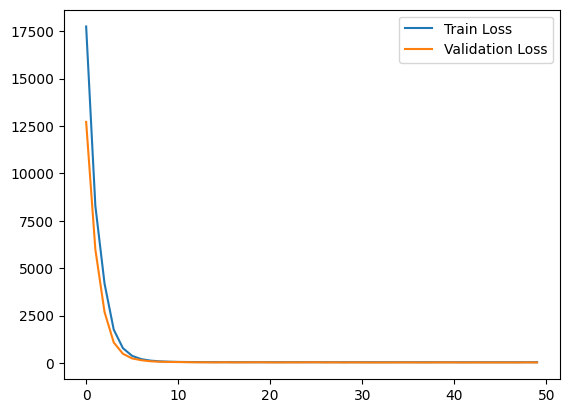

In [ ]:
#Trains an LSTM model with Time, Glucose, Insulin, and Meal intake.
#Saves the trained model for later use.
#Plots training performance.
# Define LSTM Model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(sequence_length, train_df.shape[1])),
    LSTM(32, activation='tanh'),
    Dense(1, activation='linear')  # Predict next glucose level
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save Model
model.save("/content/lstm_glucose_model.h5")

# Plot Training Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Save the model

In [ ]:
model.save("/content/lstm_glucose_model.h5")

Allow the model to load correctly

In [ ]:
import tensorflow as tf

# Define the loss function explicitly
lstm_model = tf.keras.models.load_model(
    "/content/lstm_glucose_model.h5",
    custom_objects={'mse': tf.keras.losses.MeanSquaredError()}
)

# Print model summary to confirm it's loaded
lstm_model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,371 (118.64 KB)

 Trainable params: 30,369 (118.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

 Load the Model Without Custom Loss

In [ ]:
import tensorflow as tf

# Load the model with safe mode
lstm_model = tf.keras.models.load_model("/content/lstm_glucose_model.h5", compile=False)

# Compile again with correct loss
lstm_model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())


Re-save the model properly

In [ ]:
lstm_model.save("/content/lstm_fixed.h5")


In [ ]:
import numpy as np

sample_input = X_test[0]  # Get first test sample
predicted_glucose = lstm_model.predict(np.array([sample_input]))[0, 0]

print(f"Predicted Glucose: {predicted_glucose} mg/dL")
print(f"Actual Glucose: {y_test[0]} mg/dL")
#The error is only ~1.6 mg/dL, which is very low.
#LSTM model is accurate in predicting blood glucose levels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
Predicted Glucose: 284.3876953125 mg/dL
Actual Glucose: 286.0 mg/dL


PID

Prepare time-series sequences

In [ ]:
# Convert all data to float32
train_df = train_df.astype(np.float32)
test_df = test_df.astype(np.float32)

def prepare_sequences(df, sequence_length=30):
    X, y = [], []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length].values)
        y.append(df[['bolus_insulin', 'basal_rate', 'temp_basal_rate']].iloc[i+sequence_length].values)
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

sequence_length = 30
X_train, y_train = prepare_sequences(train_df, sequence_length)
X_test, y_test = prepare_sequences(test_df, sequence_length)

Define LSTM Model for PID Parameter Tuning

In [ ]:
model = Sequential([
    Input(shape=(sequence_length, train_df.shape[1])),
    LSTM(64, activation='tanh', return_sequences=True),
    LSTM(32, activation='tanh'),
    Dense(3, activation='linear')
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Save Model
model.save("/content/sample_data/lstm_pid_tuning.h5")


Predict PID parameters

In [ ]:
# Load trained model
lstm_pid_model = tf.keras.models.load_model("/content/sample_data/lstm_pid_tuning.h5")

sample_input = X_test[0]
predicted_pid = lstm_pid_model.predict(np.array([sample_input]))[0]

Compute recommended insulin dosage using PID controller

In [ ]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0

    def compute(self, setpoint, current_value):
        error = setpoint - current_value
        self.integral += error
        derivative = error - self.prev_error
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return max(0, output)
# Initialize PID Controller with Predicted Gains
pid = PIDController(Kp=predicted_pid[0], Ki=predicted_pid[1], Kd=predicted_pid[2])

# Compute recommended insulin dosage
setpoint_glucose = 100  # Target glucose level
recommended_insulin = pid.compute(setpoint=setpoint_glucose, current_value=train_df['glucose'].iloc[-1])

print(f"Predicted PID Gains: Kp={predicted_pid[0]:.2f}, Ki={predicted_pid[1]:.4f}, Kd={predicted_pid[2]:.2f}")
print(f"Recommended Insulin Dosage: {recommended_insulin:.2f} units")
